# Analyse et Prétraitement du Dataset FER-2013
## Système Intelligent de Reconnaissance de l’Humeur

Ce notebook présente :
- L’analyse du dataset
- Le nettoyage des images
- Le prétraitement des données
- La préparation pour l’entraînement du modèle MobileNetV2


Imports & Configuration

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight


Chemins & Classes

In [28]:
DATASET_PATH = "../data"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH  = os.path.join(DATASET_PATH, "test")

EMOTIONS = sorted([
    d for d in os.listdir(TRAIN_PATH)
    if os.path.isdir(os.path.join(TRAIN_PATH, d))
])

NUM_CLASSES = len(EMOTIONS)

print("Émotions détectées :", EMOTIONS)
print("Nombre de classes :", NUM_CLASSES)


Émotions détectées : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Nombre de classes : 7


Analyse du Dataset (Déséquilibre)

In [29]:
def count_images(path):
    counts = {}
    for emotion in os.listdir(path):
        emotion_path = os.path.join(path, emotion)
        if os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
    return counts

train_count = count_images(TRAIN_PATH)
test_count  = count_images(TEST_PATH)

print("Train :", train_count)
print("Test  :", test_count)


Train : {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Test  : {'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


Visualisation

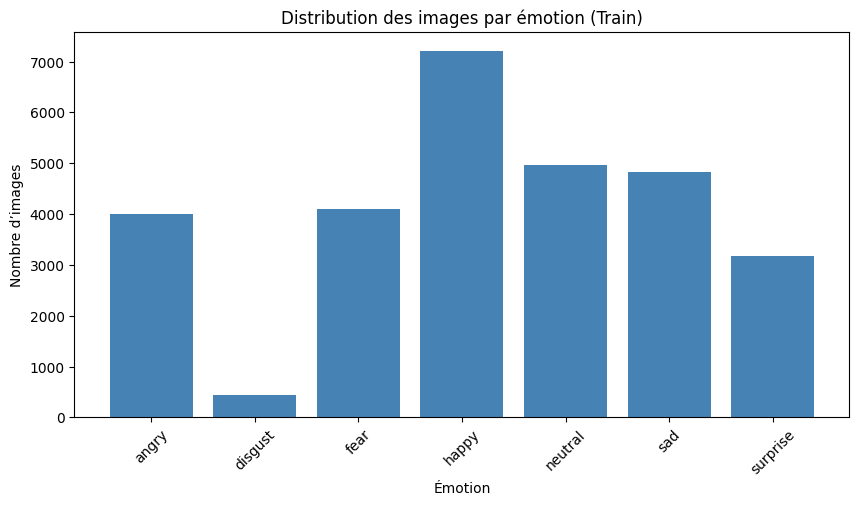

In [30]:
plt.figure(figsize=(10,5))
plt.bar(train_count.keys(), train_count.values(), color="steelblue")
plt.title("Distribution des images par émotion (Train)")
plt.xlabel("Émotion")
plt.ylabel("Nombre d’images")
plt.xticks(rotation=45)
plt.show()


Visualisation d’Exemples

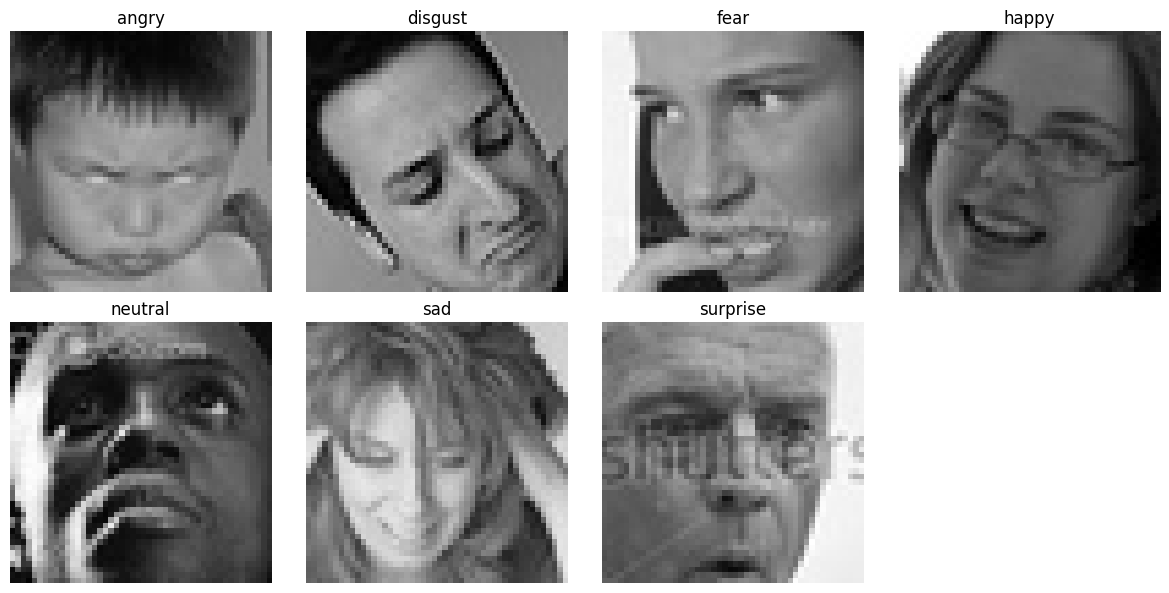

In [31]:
plt.figure(figsize=(12,6))

for i, emotion in enumerate(EMOTIONS):
    img_path = os.path.join(
        TRAIN_PATH,
        emotion,
        os.listdir(os.path.join(TRAIN_PATH, emotion))[0]
    )
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis("off")

plt.tight_layout()
plt.show()

Suppression des Images Corrompues (Critique)

In [32]:
def remove_corrupted_images(base_path):
    removed = 0
    for emotion in os.listdir(base_path):
        emotion_path = os.path.join(base_path, emotion)
        if not os.path.isdir(emotion_path):
            continue

        for img_name in tqdm(os.listdir(emotion_path), desc=emotion):
            img_path = os.path.join(emotion_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                os.remove(img_path)
                removed += 1

    print(f"Images corrompues supprimées : {removed}")

remove_corrupted_images(TRAIN_PATH)
remove_corrupted_images(TEST_PATH)

surprise: 100%|██████████| 3171/3171 [00:31<00:00, 102.10it/s]


Images corrompues supprimées : 0


surprise: 100%|██████████| 831/831 [00:06<00:00, 126.28it/s]

Images corrompues supprimées : 0


Préprocessing (OPTIMISÉ POUR TRANSFER LEARNING)

In [33]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [34]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Vérification Finale des Données

In [35]:
images, labels = next(train_generator)

print("Images shape :", images.shape)
print("Labels shape :", labels.shape)
print("Pixel min :", images.min())
print("Pixel max :", images.max())


Images shape : (32, 224, 224, 3)
Labels shape : (32, 7)
Pixel min : -1.0
Pixel max : 1.0


In [36]:
print("\nMapping des classes :")
for emotion, idx in train_generator.class_indices.items():
    print(f"{idx} → {emotion}")


Mapping des classes :
0 → angry
1 → disgust
2 → fear
3 → happy
4 → neutral
5 → sad
6 → surprise


Pondération des Classes (ESSENTIEL)

In [37]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights :", class_weights)

Class Weights : {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


Conclusion du Notebook 01

✔ Dataset nettoyé
✔ Déséquilibre analysé et corrigé
✔ Préprocessing 100% compatible MobileNetV2 / EfficientNet
✔ Générateurs robustes
✔ Prêt pour entraînement sans fuite de données